## PID FOR FED-BATCH

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import curve_fit, minimize

In [36]:
# Kinetic parameters

mu_max = 0.8564       # 1/h
Ks = 0.1707           # g/L
Yxs = 0.4066        # g/g
Sin = 286.0           # g/L``
V0 = 1.7              # L, initial volume
X0 = 4.9              # g/L, initial biomass
S0 = 1.673            # g/L, initial substrate
F0 = 0.1              # L/h
K_I = 33              # Inhibition constant
K_D = 0.03            # Decay coefficient

# Αρχικές συνθήκες
X0 = 4.9
S0 = 1.673
V0 = 1.7  #L
F0 = 0 #L/h

# PID Step
dt = 0.1

# Absolute time
At=6
time_range=np.arange(0,At+dt,dt)
#Simulation Steps
SS=int(At/dt)


In [37]:
class PID:
    def __init__(self,params : list,set_point,F_bnds):
        self.Kp,self.Ki,self.Kd=params
        self.set=set_point
        self.integral=0
        self.previous=0
        self.F_min,self.F_max=F_bnds
       
    
    def update(self,X,dt):
        err=self.set-X
        self.integral +=err*dt #Ολοκλήρωμα
        der_err= (err - self.previous) / dt
        
        output = self.Kp * err + self.Ki * self.integral + self.Kd * der_err

        # Step 2: Clip output to actuator limits
        output_clipped = np.clip(output, self.F_min, self.F_max)

        # Step 3: Anti-windup - adjust integral if saturated
        if output != output_clipped:
            self.integral -= err * dt  # Revert the last integration

        self.previous = err
        return output_clipped  # Return clipped output

# Ορισμός των διαφορικών εξισώσεων που περιγράφουν το μοντέλο
def actual_model(t,y, F):
    X, S, V = y
    S = max(S, 0)
    mu = mu_max * S / (Ks + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - K_D * X
    dS_dt = -(1 / Yxs) * mu * X + (F / V) * (Sin - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

def assumed_model(t,y,F):
    X, S, V = y
    S=max(S,0)
    dX_dt = (mu_max * S / (Ks + S)) * X - (F / V) * X
    dS_dt = -(1 / Yxs) * (mu_max * S / (Ks + S)) * X + (F / V) * (Sin - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])


In [74]:
params=[0.00688,0.0004,0.0] # PID parameters
F_bnds=(0,1)
controller=PID(params,30,F_bnds)

# Αρχικοποίηση συστήματος
X = np.zeros(SS+1)
S = np.zeros(SS+1)
V = np.zeros(SS+1)
F_PID = np.zeros(SS+1)
np.random.seed(0) # Για αναπαραγωγιμότητα

X[0], S[0], V[0], F_PID[0] = X0, S0, V0, F0

# PID FEEDBACK LOOP
for step in range(SS):
    t = step * dt
    X_pid = X[step] +np.random.normal(0,X[step]*0.05) # Η τιμή του X που θα χρησιμοποιηθεί για τον υπολογισμό του F
    F = controller.update(X_pid,dt) # Το F πρέπει να είναι μη αρνητικό
    F_PID[step+1]=F
    solution = solve_ivp(
        actual_model, t_span=(t, t+dt), y0=[X[step], S[step], V[step]], args=(F,),
        method="RK45"
    )
    X[step+1], S[step+1], V[step+1] = solution.y[:, -1]
    # X[step+1] += np.random.normal(0, X[step+1] * 0.008) # Change the biomass noise ratio to 0.8% for the measured data, because is more accurate.
    # S[step+1] += np.random.normal(0, max(1e-6,S[step+1] * 0.03)) # Adding the max(1e-6, X[step] * ratio) to avoid division-by-zero or zero noise if biomass is momentarily near 0.


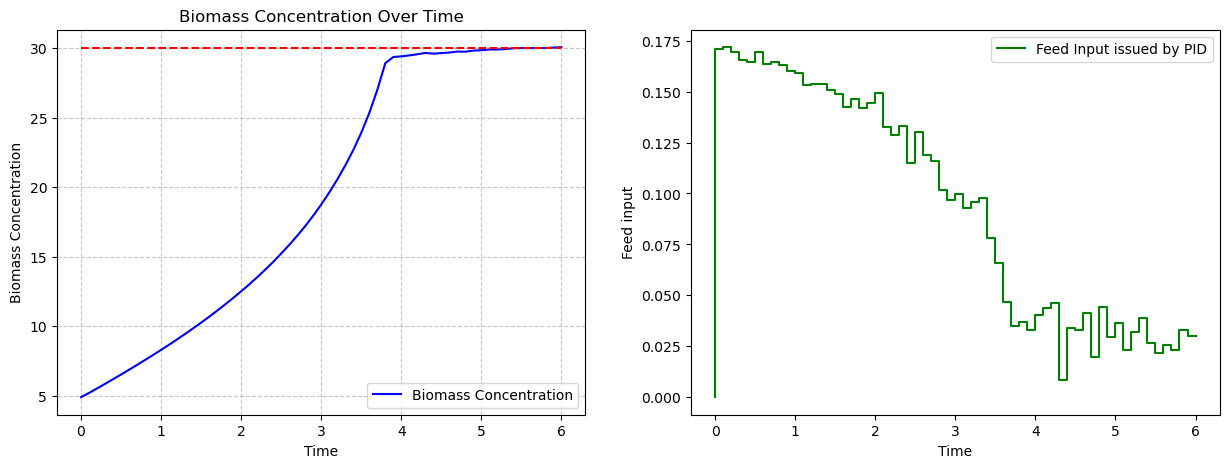

In [75]:
# Γράφημα αποτελεσμάτων
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


ax = axs[0]
ax.plot(time_range, X, 'b-',label="Biomass Concentration")
ax.plot(time_range,[controller.set]*len(time_range),'r--')
ax.set_xlabel('Time')
ax.set_ylabel('Biomass Concentration')
ax.legend()
plt.grid()
# Enhance the plot aesthetics
ax.set_title('Biomass Concentration Over Time')
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.7)

ax = axs[1]
ax.step(time_range, F_PID, 'g-',label="Feed Input issued by PID")
ax.set_xlabel('Time')
ax.set_ylabel('Feed input')
ax.legend()

plt.grid()
plt.show()

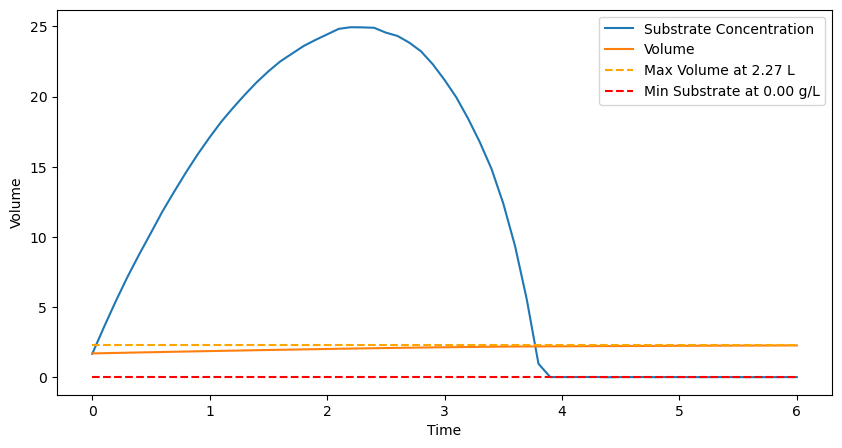

In [76]:
fig,ax=plt.subplots(figsize=(10,5))
plt.plot(time_range,S,label="Substrate Concentration")
plt.plot(time_range,V,label="Volume")
plt.hlines(max(V),0,At,linestyle='--',color='orange',label=f'Max Volume at {max(V):.2f} L')
plt.hlines(min(S),0,At,linestyle='--',color='red',label=f'Min Substrate at {min(S):.2f} g/L')
plt.xlabel('Time') 
plt.ylabel('Volume')
plt.legend()
plt.show()

## PID PARAMS ESTIMATION

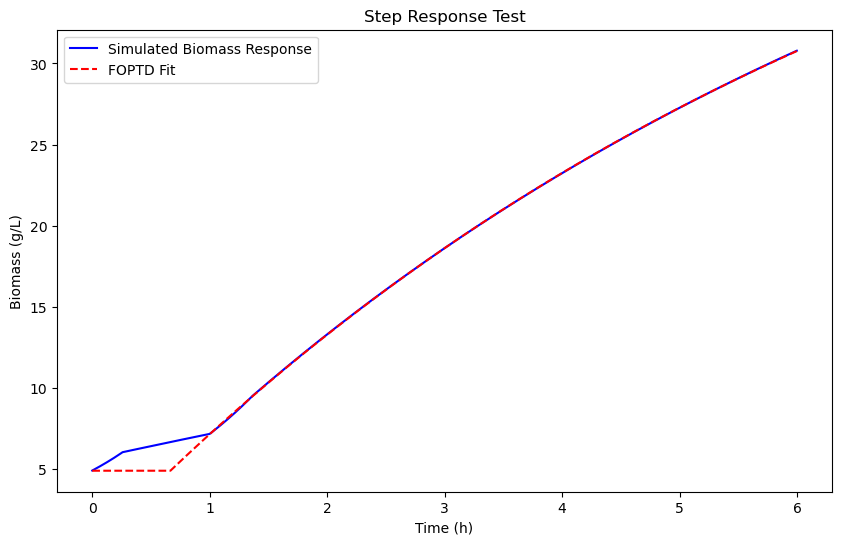

Estimated Parameters:
  Process Gain, K = 653.6729 (g/L per L/h)
  Time Constant, tau = 7.1119 h
  Dead Time, L = 0.6652 h

IMC-based PID Tuning Parameters:
  Kp (proportional gain) = 0.0065
  Ki (integral gain)     = 0.0009
  Kd (derivative gain)   = 0.0043


In [ ]:
# System parameters
mu_max = 0.8564       # 1/h
Ks = 0.1707           # g/L
Yxs = 0.4066        # g/g
Sin = 286.0           # g/L
V0 = 1.7              # L, initial volume
X0 = 4.9              # g/L, initial biomass
S0 = 1.673             # g/L, initial substrate
t_sim = 6             # simulation time (hours)

# Define the bioreactor model (fed-batch, with variable volume)
def bioreactor(y, t, F):
    """
    ODEs for the fed-batch reactor.
    
    y[0] = X (biomass, g/L)
    y[1] = S (substrate, g/L)
    y[2] = V (volume, L)
    
    F: feed rate (L/h)
    """
    X, S, V = y
    S = max(S, 0)
    mu = mu_max * S / (Ks + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - K_D * X
    dS_dt = -(1 / Yxs) * mu * X + (F / V) * (Sin - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

# -----------------------------
# Step Response Simulation
# -----------------------------
def step_response_simulation(baseline_F,step_time=1.0, F_step=0.1):
    """
    Simulate the step response.
    
    Before step_time, feed F = baseline_F.
    After step_time, feed F is set to F_step (maximum allowable, now 0.1 L/h).
    
    Returns:
      t_vals: time vector (hours)
      X_vals: biomass response (g/L)
    """
    t = np.linspace(0, t_sim, 2000)
    X_vals = []
    y = [X0, S0, V0]  # initial state
    
    for i in range(len(t) - 1):
        if t[i] < step_time:
            F = baseline_F
        else:
            F = F_step  # step to new maximum feed rate
        # Integrate for one time step
        y = odeint(bioreactor, y, [t[i], t[i+1]], args=(F,))[-1]
        X_vals.append(y[0])
    return t[:-1], np.array(X_vals)

# -----------------------------
# FOPTD Model for Curve Fitting
# -----------------------------
# Define the step amplitude (Delta F)
baseline_F = 0.025
F_step = 0.1
delta_F = F_step - baseline_F  # Now delta_F = 0.095

def foptd(t, K, tau, L):
    """
    FOPTD model for the step response.
    
    For t < L, output is X0.
    For t >= L, output follows:
      X(t) = X0 + (K * delta_F) * (1 - exp(-(t-L)/tau))
      
    K: process gain (g/L per unit L/h)
    tau: time constant (h)
    L: dead time (h)
    """
    return np.where(t < L, X0, X0 + (K * delta_F) * (1 - np.exp(-(t - L) / tau)))

# -----------------------------
# Main Routine: Step Response, Parameter Estimation, and IMC PID Tuning
# -----------------------------
def step_response_pid_tuning(baseline_F,step_time=0.5, F_step=0.1, lambda_val=1.0):
    # 1. Simulate the step response
    t_vals, X_vals = step_response_simulation(baseline_F,step_time, F_step)
    
    # Plot the step response data
    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, X_vals, 'b', label='Simulated Biomass Response')
    plt.xlabel('Time (h)')
    plt.ylabel('Biomass (g/L)')
    plt.title('Step Response Test')
    
    # 2. Fit the FOPTD model to the step response data.
    # Choose data after a little bit past the step (to avoid the initial flat region)
    mask = t_vals > (step_time + 0.1)
    t_fit = t_vals[mask]
    X_fit = X_vals[mask]
    
    # Initial guess for parameters:
    # Estimate K as (final biomass - X0) / delta_F.
    K_guess = (X_fit[-1] - X0) / delta_F
    tau_guess = 1.0  # initial guess (hours)
    L_guess = 0.5    # initial guess for dead time (hours)
    p0 = [K_guess, tau_guess, L_guess]
    
    try:
        popt, pcov = curve_fit(foptd, t_fit, X_fit, p0=p0, bounds=(0, np.inf))
        K_est, tau_est, L_est = popt
    except RuntimeError:
        print("Curve fitting failed. Check initial guesses or data quality.")
        return None

    # Plot the fitted model
    X_model = foptd(t_vals, K_est, tau_est, L_est)
    plt.plot(t_vals, X_model, 'r--', label='FOPTD Fit')
    plt.legend()
    plt.show()
    
    print(f"Estimated Parameters:\n  Process Gain, K = {K_est:.4f} (g/L per L/h)\n  Time Constant, tau = {tau_est:.4f} h\n  Dead Time, L = {L_est:.4f} h")
    
    # 3. IMC-based PID tuning
    # Using common IMC formulas for a FOPTD model:
    # Kp = tau / (K * (lambda + L))
    # Ti = tau  and Td = L
    Kp_pid = tau_est / (K_est * (lambda_val + L_est))
    Ki_pid = Kp_pid / tau_est   # (1/Ti)
    Kd_pid = Kp_pid * L_est
    
    print("\nIMC-based PID Tuning Parameters:")
    print(f"  Kp (proportional gain) = {Kp_pid:.4f}")
    print(f"  Ki (integral gain)     = {Ki_pid:.4f}")
    print(f"  Kd (derivative gain)   = {Kd_pid:.4f}")
    
    return {"K": K_est, "tau": tau_est, "L": L_est,
            "Kp": Kp_pid, "Ki": Ki_pid, "Kd": Kd_pid}

# Run the step response PID tuning routine with the updated F_step
params = step_response_pid_tuning(baseline_F,step_time=1.0, F_step=0.1, lambda_val=1.0)
